# Causal inference with causal Bayesian networks using R's bnlearn package and Pyro.ai

**Note**: This notebook contains both R and python code. Therefore, in order to run this notebook, you must have both an R kernel and a python kernel configured in the jupyter notebook or jupyter lab session. The first part of this notebook will run under an R kernel (with bnlearn and graphviz installed).  The second part will run under a python kernel (with pyro installed)



In [1]:
library(bnlearn)


Attaching package: ‘bnlearn’


The following object is masked from ‘package:stats’:

    sigma




## Utility functions for displaying symbolic and numerical conditional probabilty distributions

In [2]:
display.cpd.chart <- function(dag, iss.list){
    for( node in nodes(bn.bayes)){
        for(iss in iss.list){
            bn.bayes <- bn.fit( dag, data= survey, method= "bayes", iss=iss)
            bn.fit.barchart(bn.bayes[[node]], main = paste(node.names[[node]], 
                                                           " (ISS=", iss, ")" ,sep=""),
            xlab =display.cpd.str(dag, node) , ylab = "Probability mass")
        }
    }
}

display.cpd.str  <- function( dag, node ){
    if( length(parents(dag, node)) == 0){
        paste("Pr(",node,")",sep="")
    } else {
        paste("Pr(",node,"|",paste(parents(dag,node), collapse=","),")", sep="")
    }
}

## 1 Building a DAG (4 points)

A DAG maps to a factorization of the joint distribution (e.g., $P(A, B, C) == P(A)P(B|A)P(C|B)$).  In *bnlearn*, you can use the function `modelstring(dag)` to convert a DAG into a string representation of a factorization of the joint probability distribution. We can go from a string representation to a DAG using the function `model2network(string)`.



### (a) Write out the factorization of the joint distribution implied by the DAG using mathematical notation


$$P(A,S,E,O,R,T) = P(A)P(S)P(E|A,S)P(O|E)P(T|O,R)$$

### (b) Rewrite the above factorization in *bnlearn*'s string representation.


In [3]:
dagstr <- '[A][S][E|A:S][O|E][R|E][T|O:R]'
dagstr

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

### (c) Use this to create a DAG in *bnlearn*.


Loading required namespace: Rgraphviz



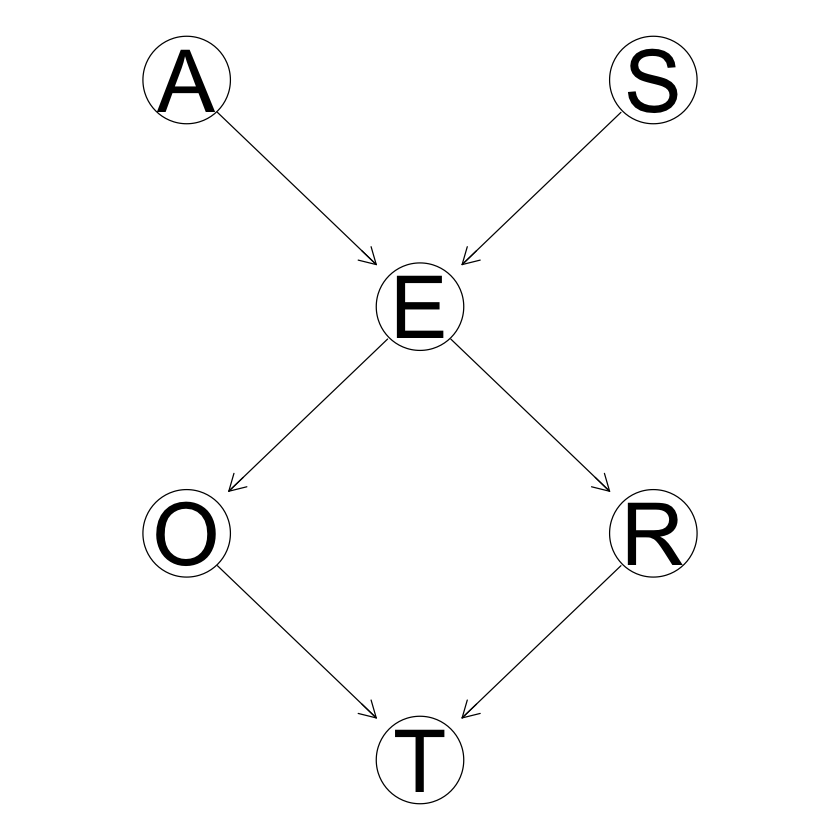

In [5]:
dagnetwork <- model2network( dagstr )
graphviz.plot(dagnetwork)

### (d) Print the class of the DAG object.


In [6]:
class(dagnetwork)

[1] "bn"

### (e) Use `graphviz.plot` to plot the DAG.

Loading required namespace: Rgraphviz



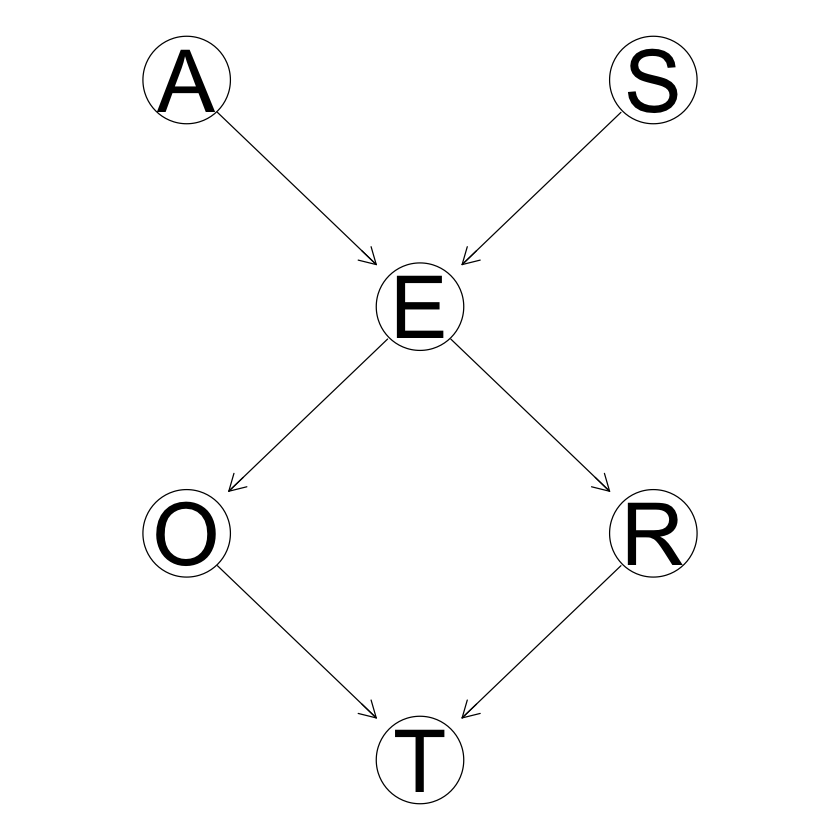

In [7]:
graphviz.plot(dagnetwork)

## 2 Experimenting with graph utilities (6 points)

### (a) Extract and print the nodes and arcs of the DAG you created in previous questions.

In [8]:
nodes(dagnetwork)

[1] "A" "E" "O" "R" "S" "T"

In [9]:
arcs(dagnetwork)

from,to
A,E
S,E
E,O
E,R
O,T
R,T


### (b) Extract and print the parents and the children of each node using `parents` and `children` functions.

In [10]:
for(node in nodes(dagnetwork)){
    cat("Parent(s) of node", node, ": ", parents( dagnetwork, node ), "\n")
    cat("Child(ren) of node ", node, ": ", children(dagnetwork, node), "\n\n")
}

Parent(s) of node A :   
Child(ren) of node  A :  E 

Parent(s) of node E :  A S 
Child(ren) of node  E :  O R 

Parent(s) of node O :  E 
Child(ren) of node  O :  T 

Parent(s) of node R :  E 
Child(ren) of node  R :  T 

Parent(s) of node S :   
Child(ren) of node  S :  E 

Parent(s) of node T :  O R 
Child(ren) of node  T :   



### (c) Use the `mb` function to extract the Markov blanket of A, E, and T.

In [11]:
for(node in c("A","E", "T")){
    cat("Markov blanket of node ", node , ": ", mb(dagnetwork, node), "\n")
}

Markov blanket of node  A :  E S 
Markov blanket of node  E :  A O R S 
Markov blanket of node  T :  O R 


### (d) Describe, in terms of the joint probability distribution and NOT in terms of the DAG the definition of a Markov blanket.

The Markov blanket of a random variable $X$, $\text{mb}(X)$ is the set of conditioned variables that results in $X$ being conditionally independent of the rest of the variables in the joint distribution.  In other words, 

$$P(X|\text{mb}(X),A) = P(X|\text{mb}(X))$$



### (e) How do you identify the Markov blanket from the DAG?

Parents, children, and parents of children of the node.

## 3 Conditional probability distribution (CPD) parameter estimation (4 points)

Bayesian network = DAG + CPD with specified parameters

(a) Fit the parameters of the DAG from the data stored in survey2.txt using Bayesian estimation, and save the result into an object of class bn.fit.  

In [7]:
survey <- read.table('survey2.txt',header=TRUE)
head(survey)

,A,R,E,O,S,T
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,adult,big,high,emp,F,car
2,adult,small,uni,emp,M,car
3,adult,big,uni,emp,F,train
4,adult,big,high,emp,M,car
5,adult,big,high,emp,M,car
6,adult,small,high,emp,F,train


#### Export the fitted conditional probability distributions for use in the Pyro section

In [8]:
bn.bayes <- bn.fit( dagnetwork, data= survey, method= "bayes") # Default iss
for(node in nodes(bn.bayes)){
    write.table(bn.bayes[[node]]$prob, 
                paste(as.character(node),
                      "-node.tab",
                      sep=""), 
                sep='\t')
}
class(bn.bayes)

[1] "bn.fit"      "bn.fit.dnet"

### (b) Play with the Bayesian prior parameter **iss** and report the changes in the parameters learned from Bayesian network. Explain the changes.

Age (A): It is recorded as young (young) for individuals below 30 years, adult (adult) for individuals between 30 and 60 years old, and old (old) for people older than 60.

Sex (S): The biological sex of individual, recorded as male (M) or female (F).

Education (E): The highest level of education or training completed by the individual, recorded either high school (high) or university degree (uni).

Occupation (O): It is recorded as an employee (emp) or a self employed (self) worker.

Residence (R): The size of the city the individual lives in, recorded as small (small) or big (big).

Travel (T): The means of transport favoured by the individual, recorded as car (car), train (train) or other (other)

In [9]:
node.names <- c("Age","Education","Occupation","Residence","Sex","Travel")
names(node.names) <- nodes(dagnetwork) 
node.names

A            E            O            R            S            T 
       "Age"  "Education" "Occupation"  "Residence"        "Sex"     "Travel"

Loading required namespace: lattice



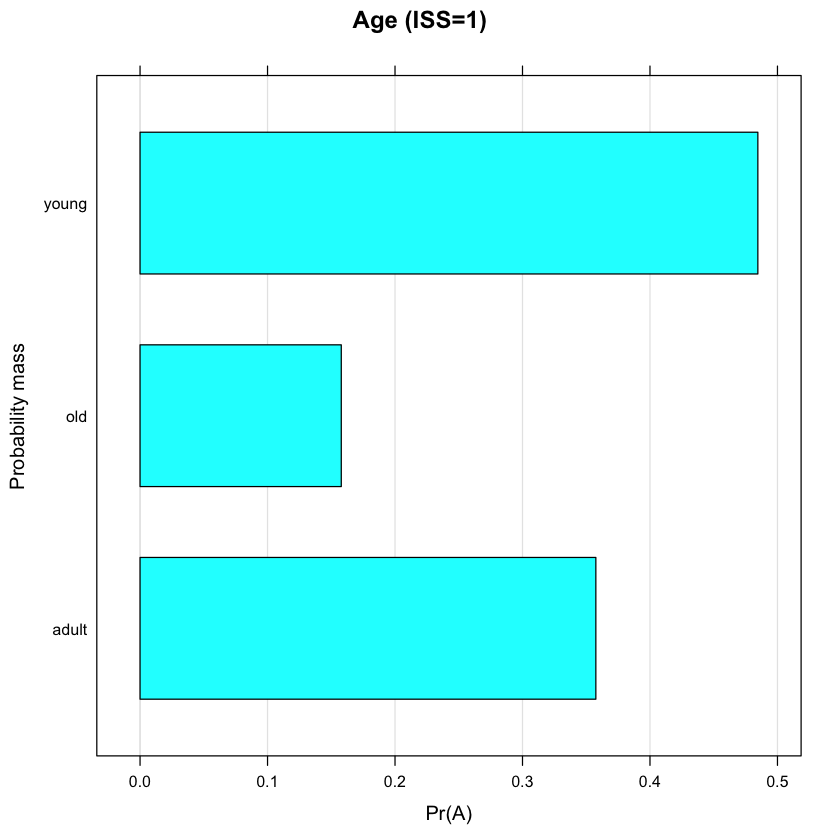

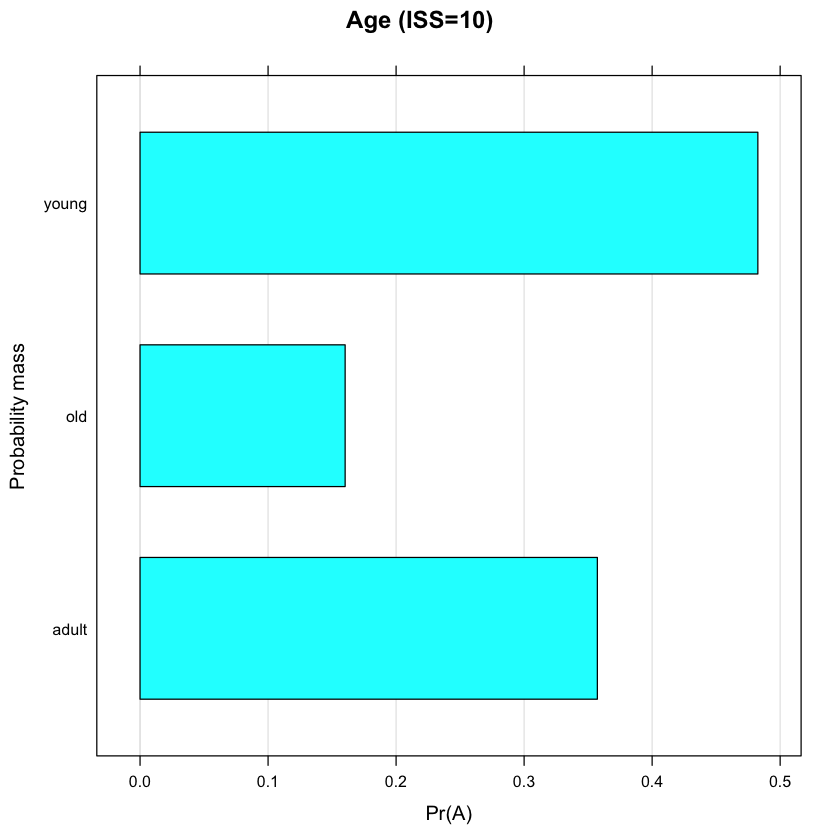

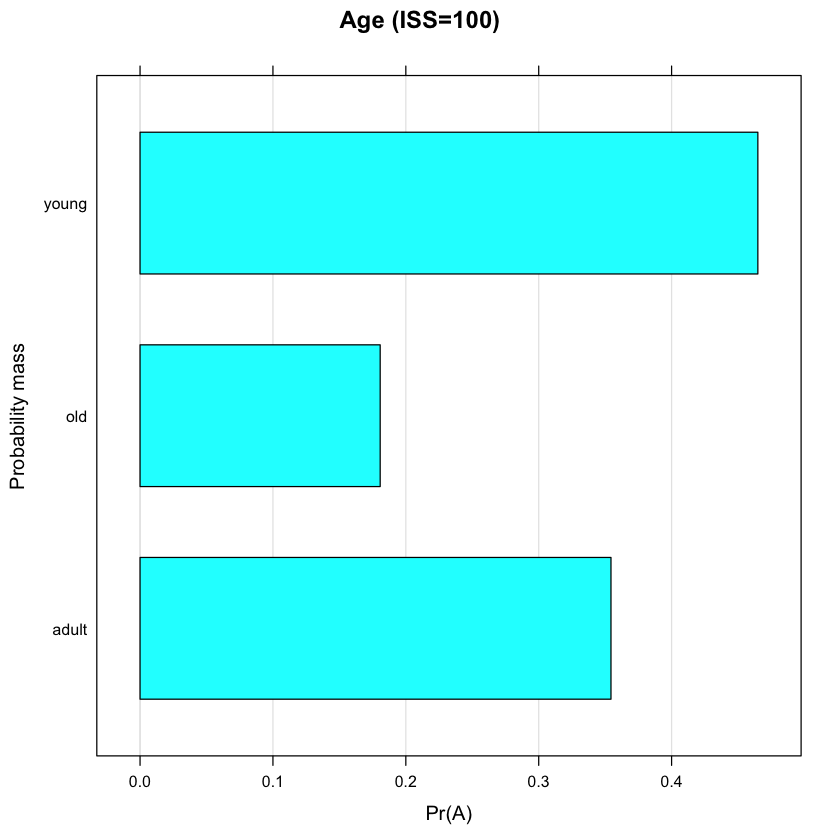

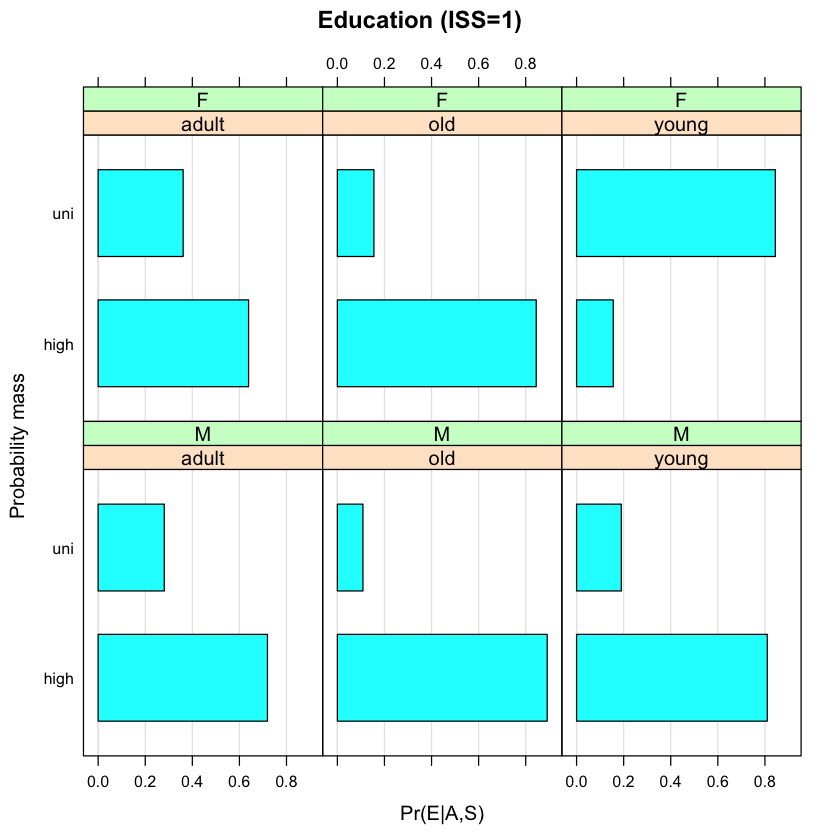

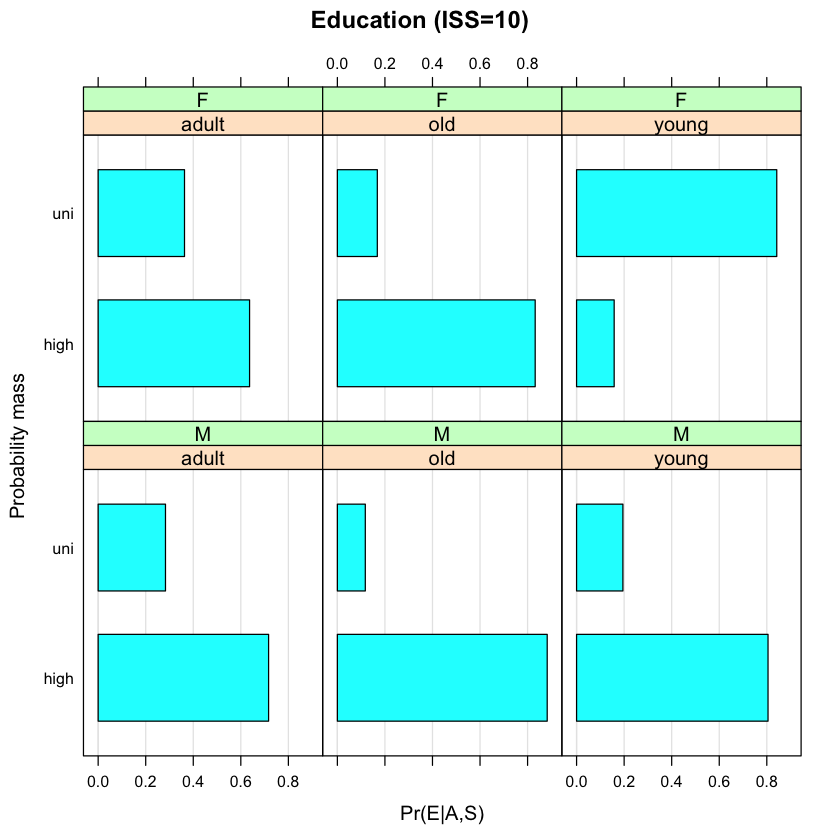

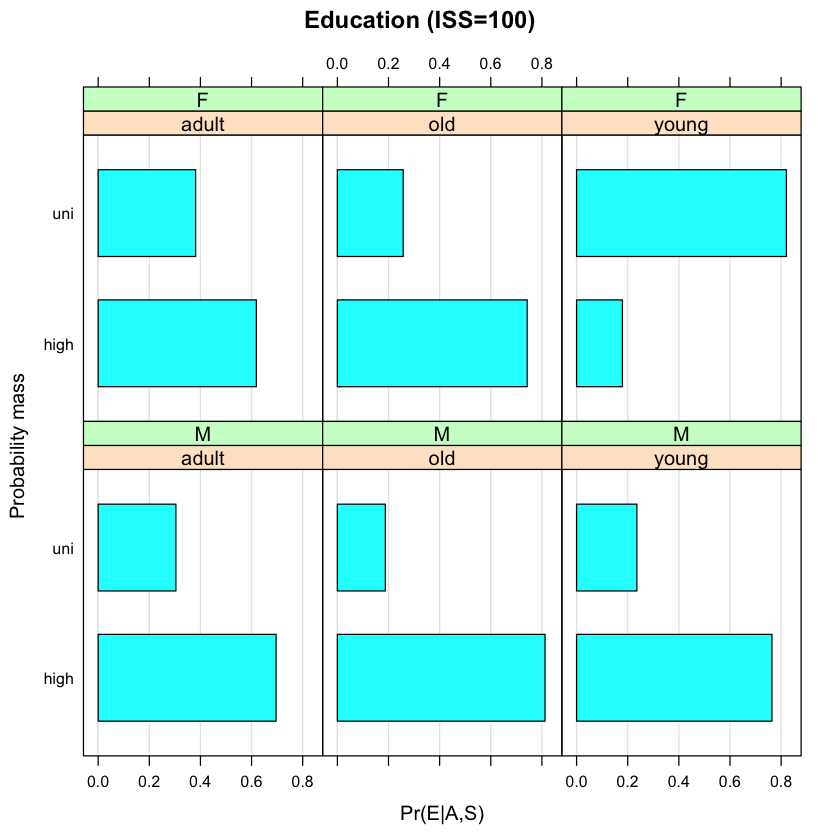

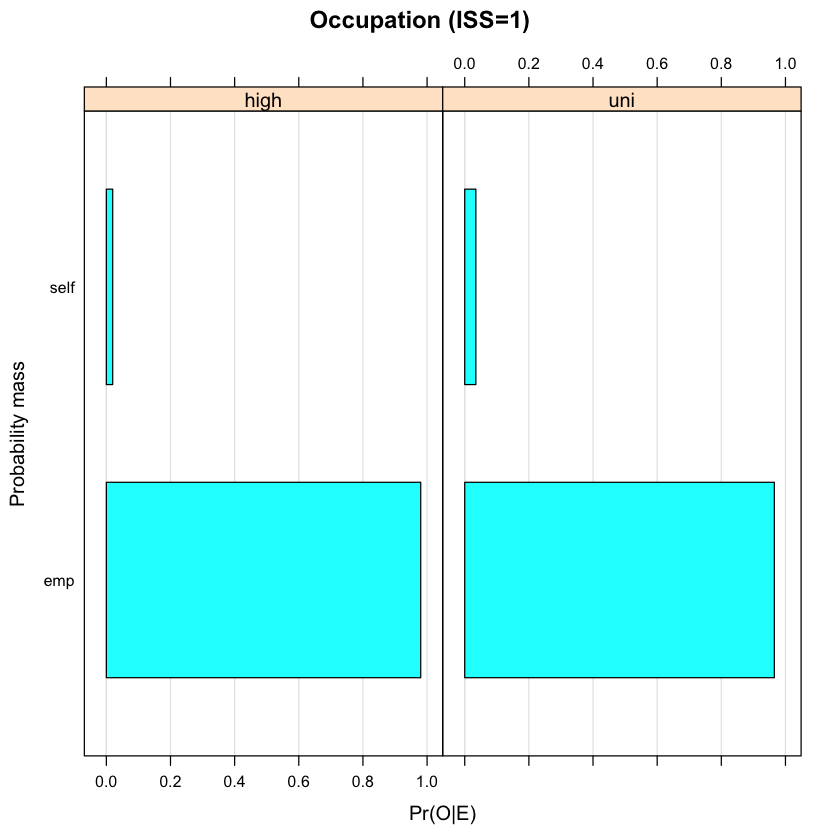

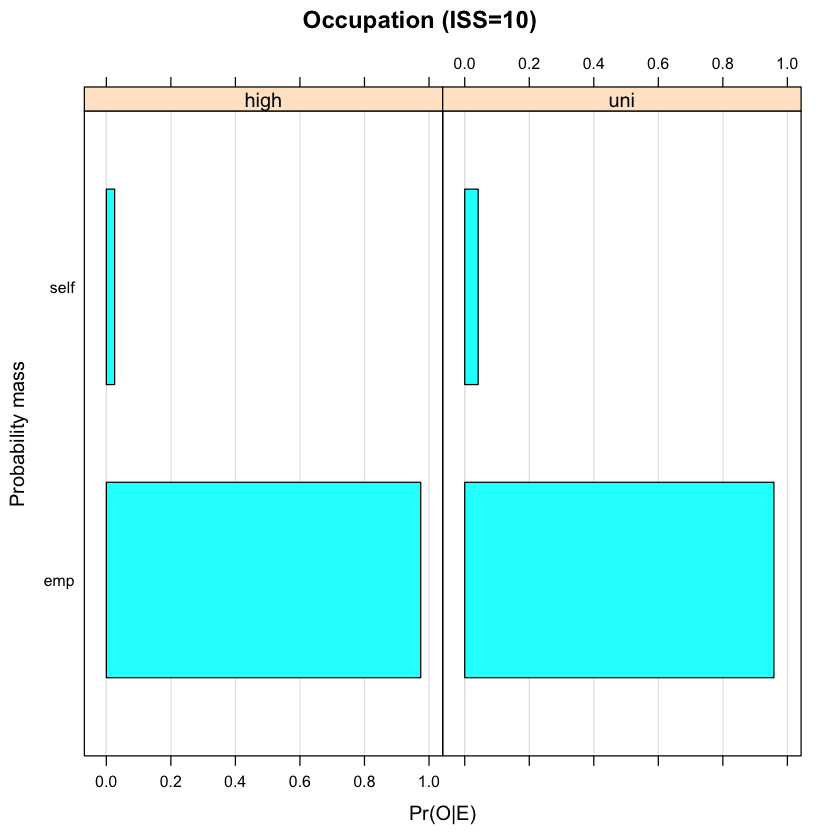

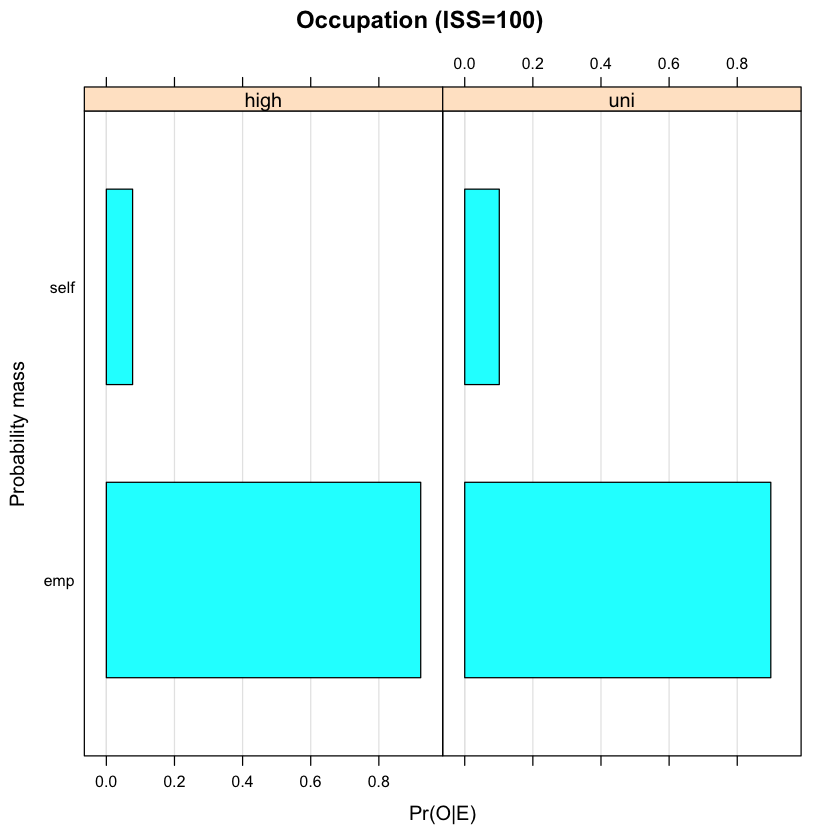

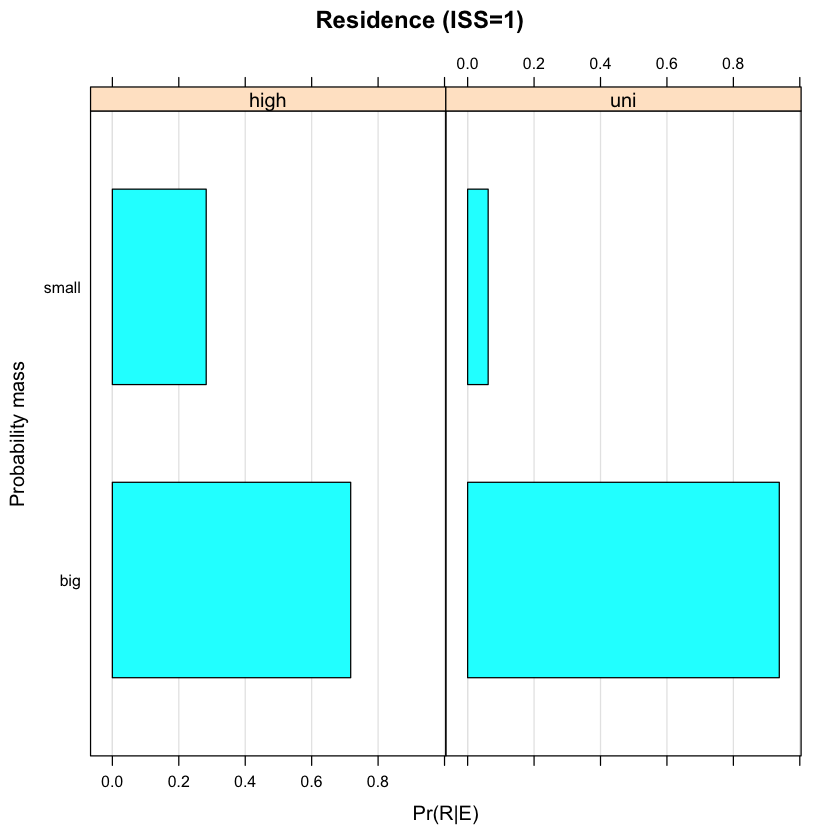

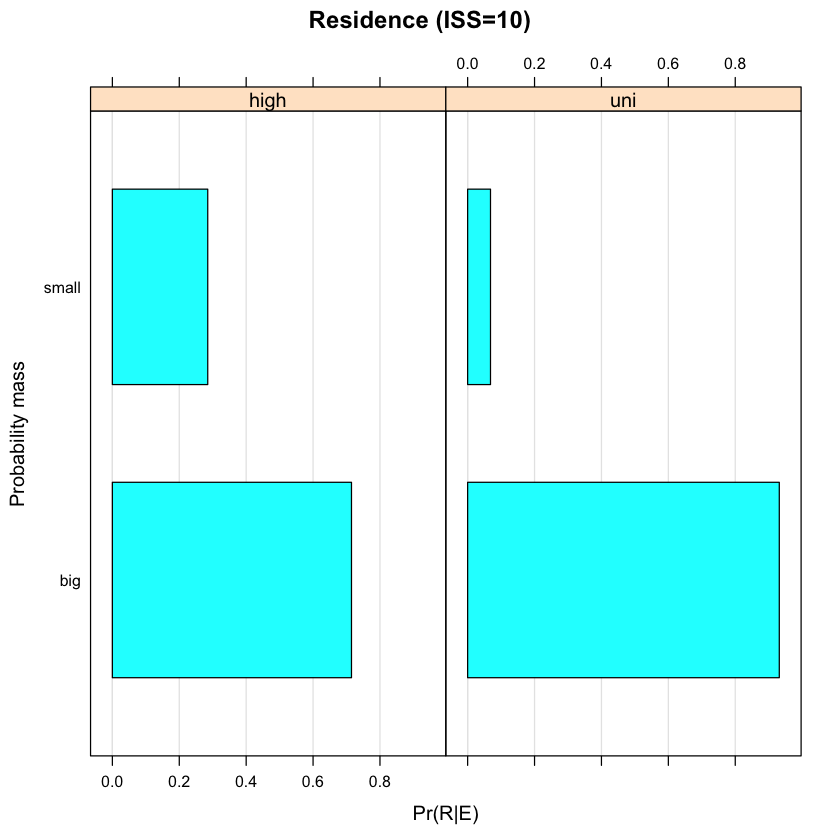

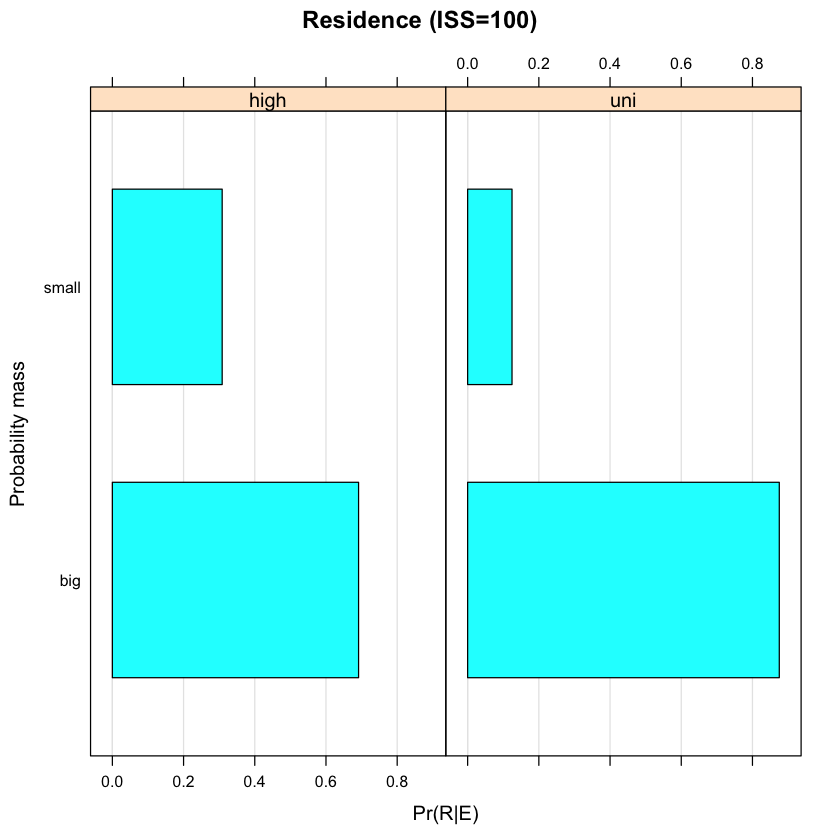

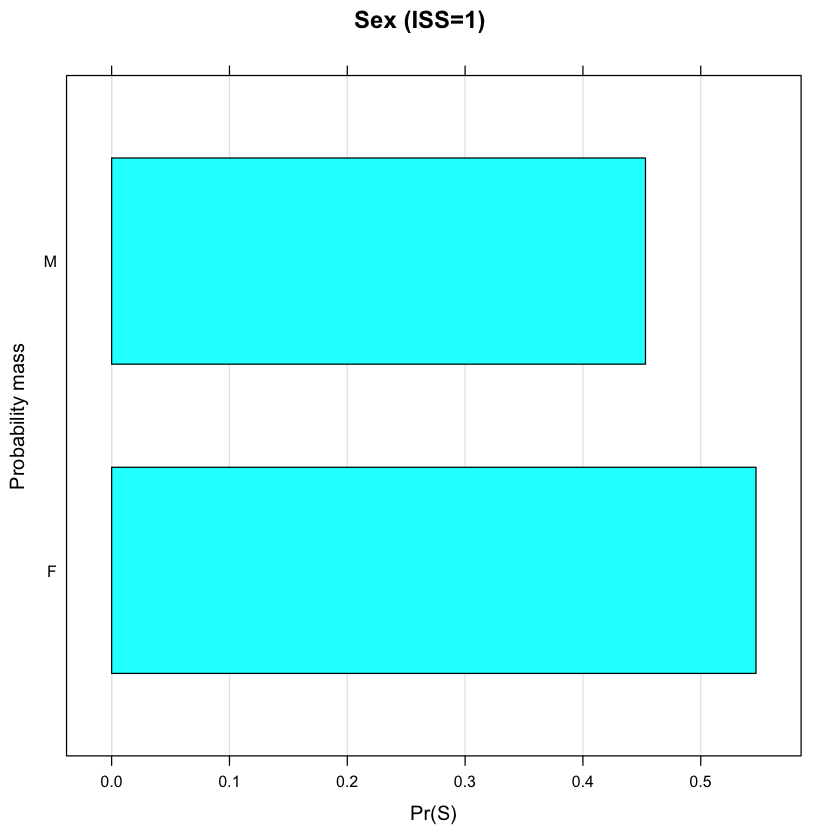

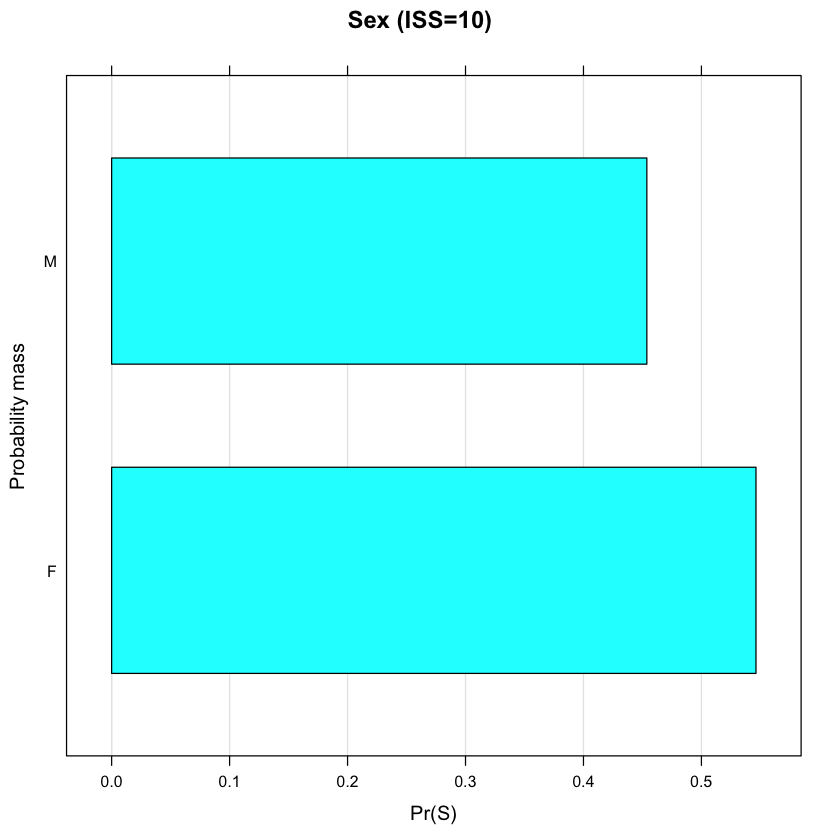

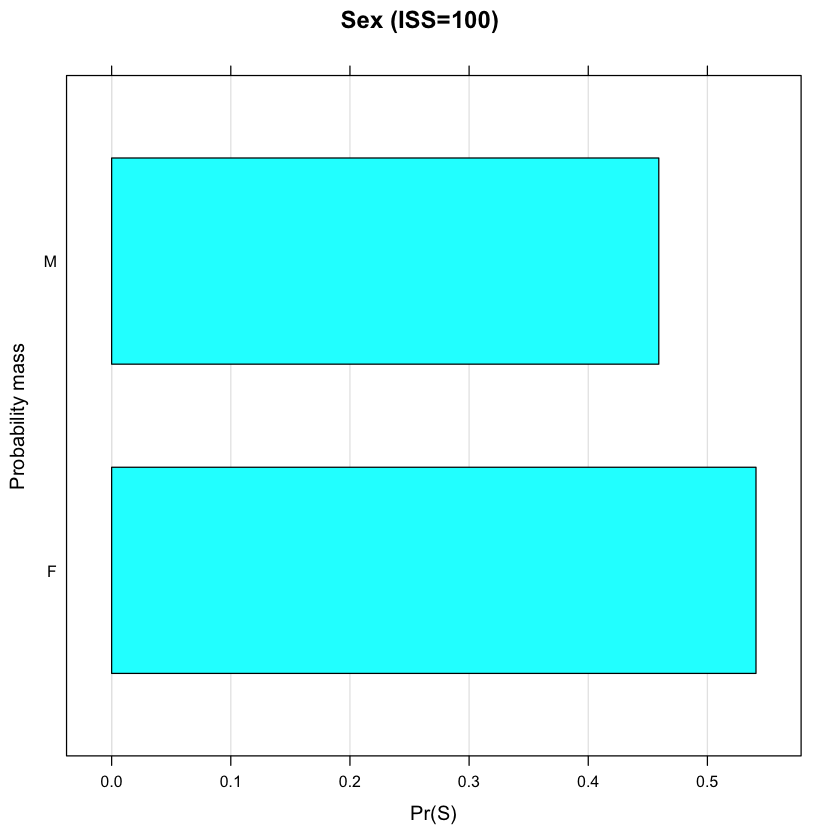

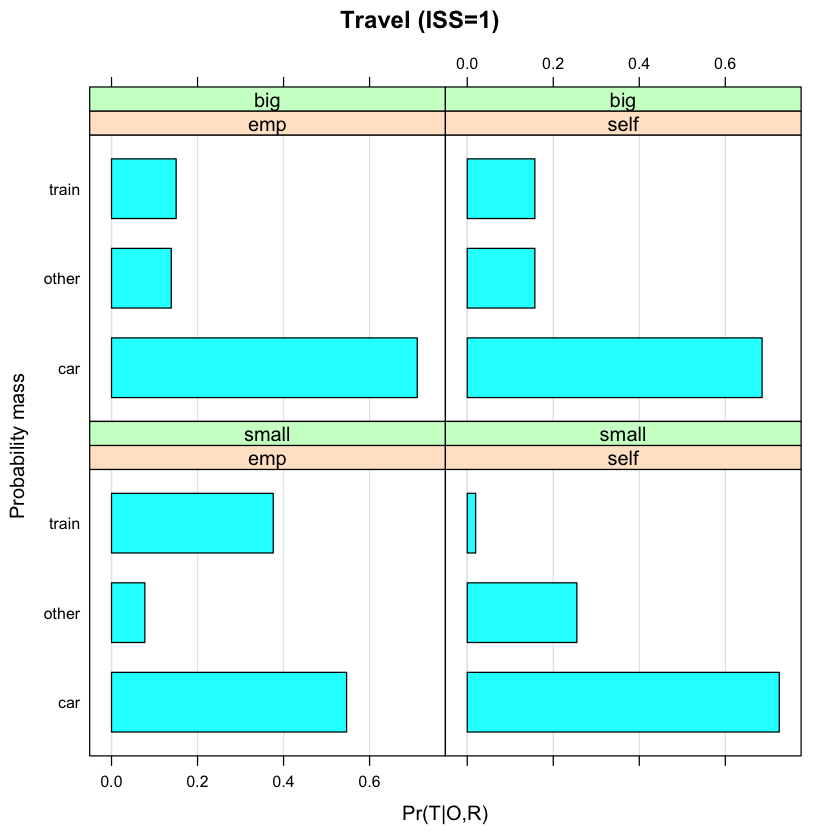

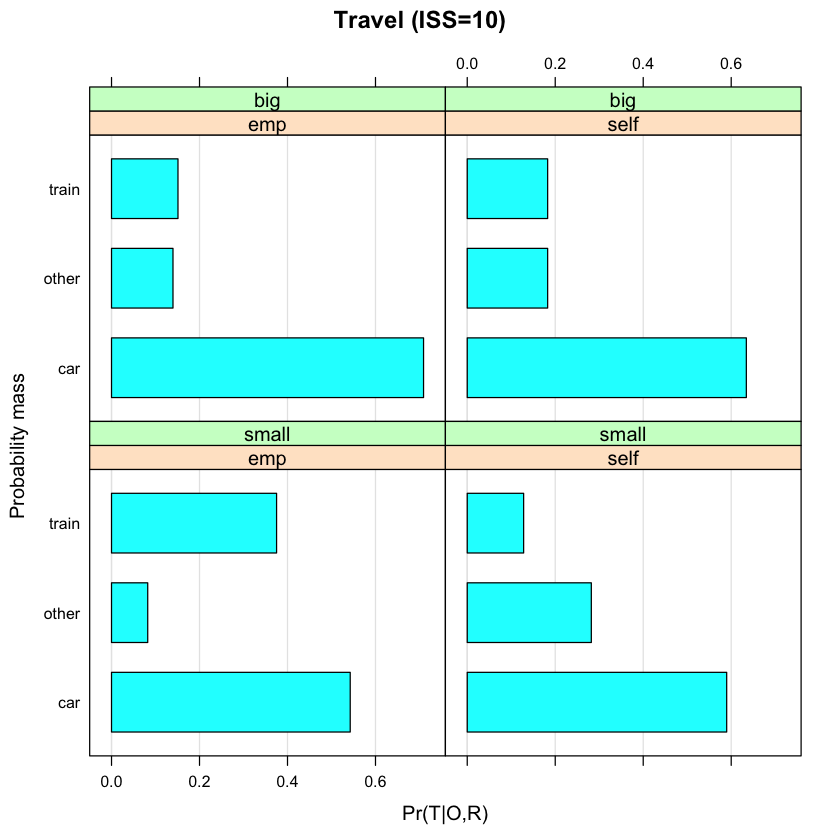

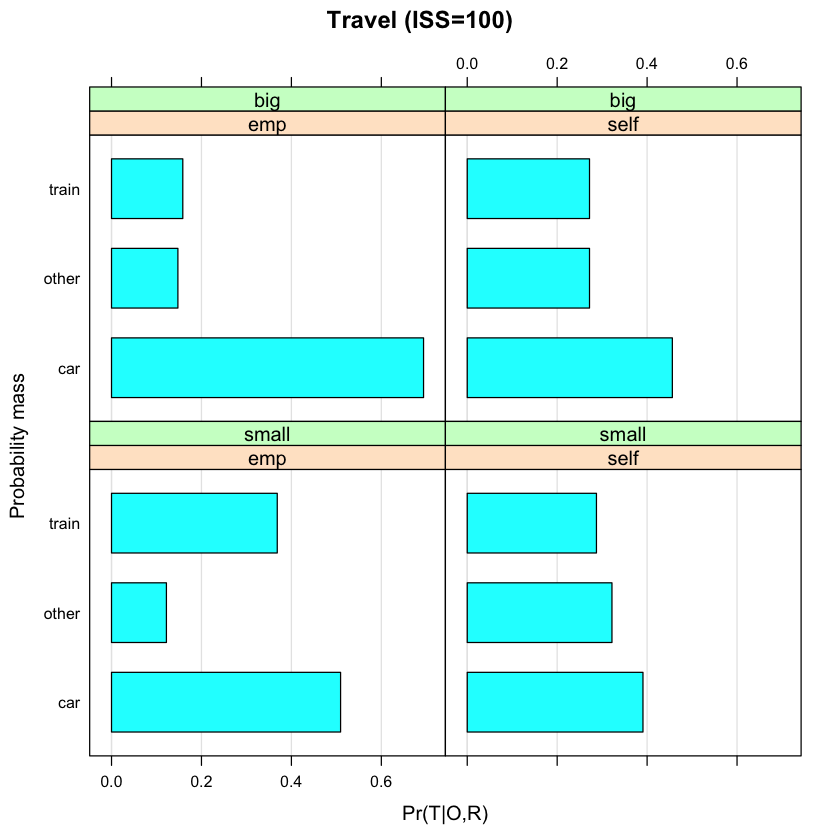

In [10]:

display.cpd.chart(dagnetwork, c(1,10,100))

## 4 Graph manipulation (4 points)


### (a) Create a copy of the DAG (e.g. `dag2 <- dag`).  Remove the arc from Education to Occupation, and plot the result with `graphviz.plot`.

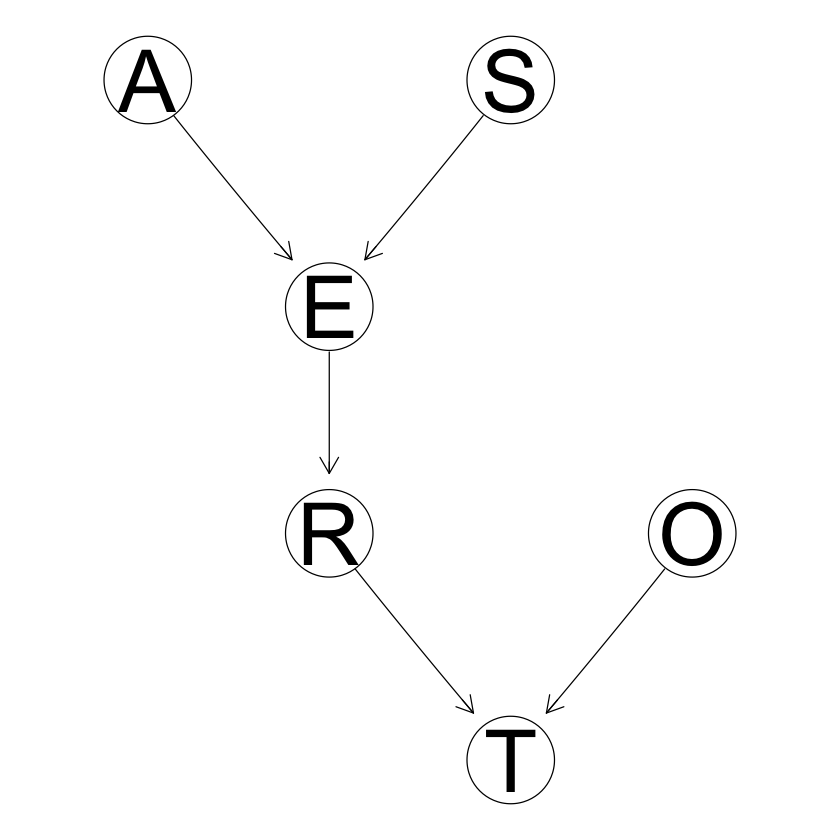

In [12]:
dag2 <- dagnetwork
dag2 <- drop.arc(dag2,'E','O')
graphviz.plot(dag2)

### (b) Fit the parameters of the modified network. Which local distributions change, and how?

#### Answer:

Ancestors and siblings of the intervention (Age, Sex, Residence, and Education) do not change, but nodes downstream of the intervention  (Occupation and Travel) do change. In particular, Occupation changes from a conditional distribution $P(O|E)$ to an unconditional distribution $P(O)$. Travel's distribution shifts, but it remains a conditional probability distribution $P(T|O,R)$


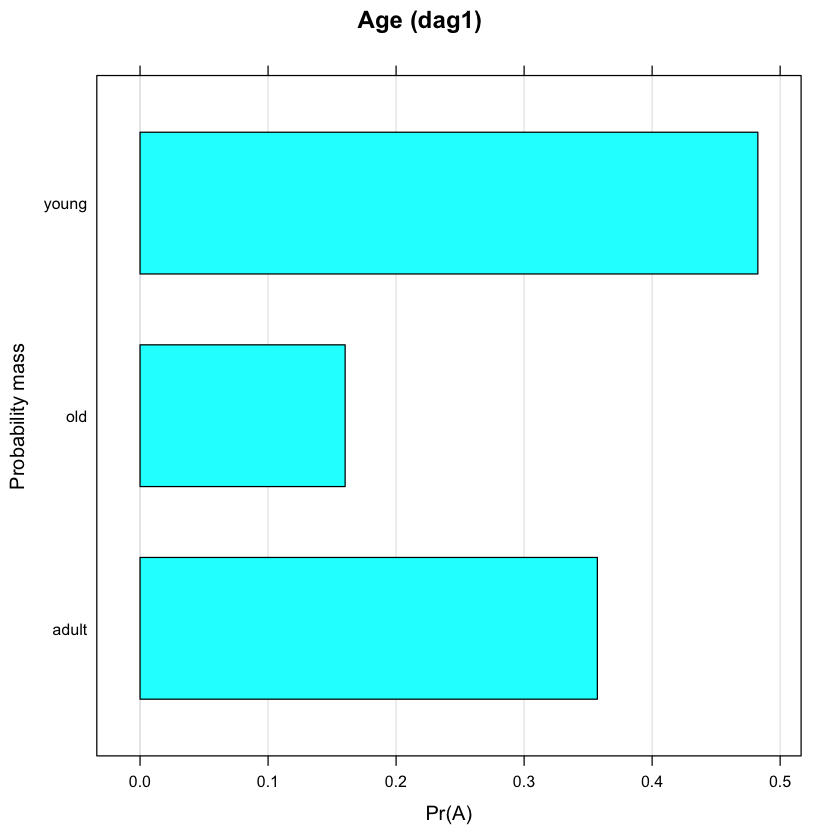

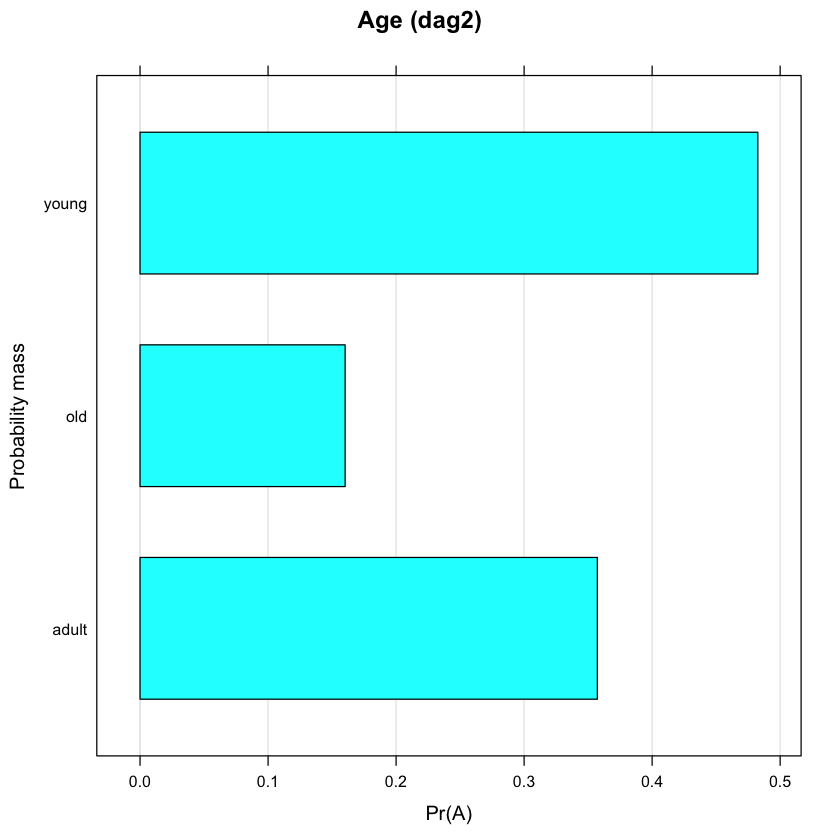

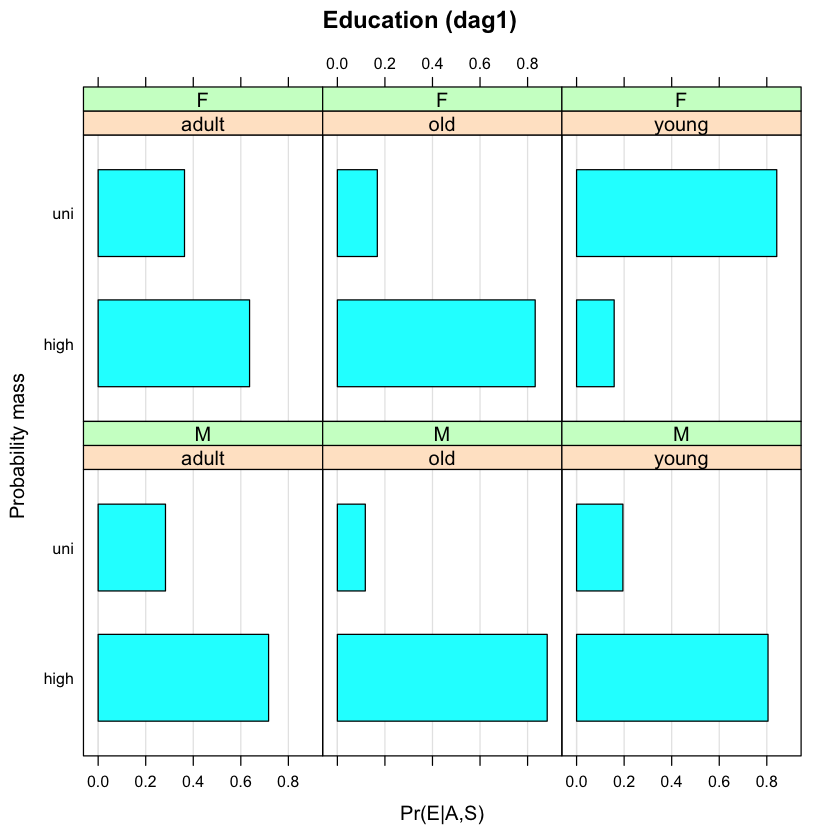

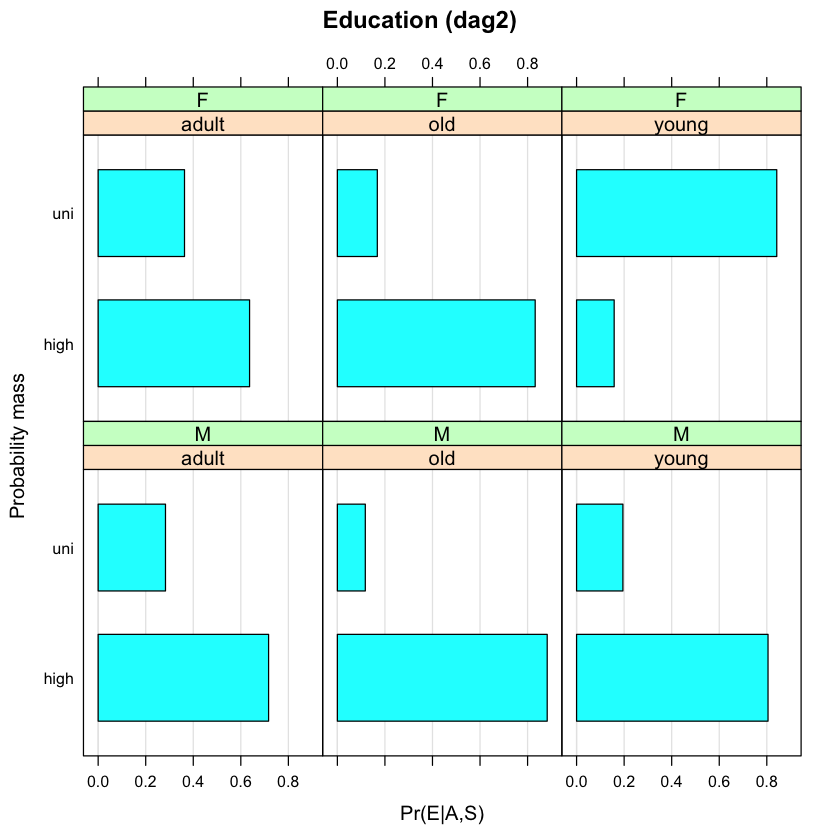

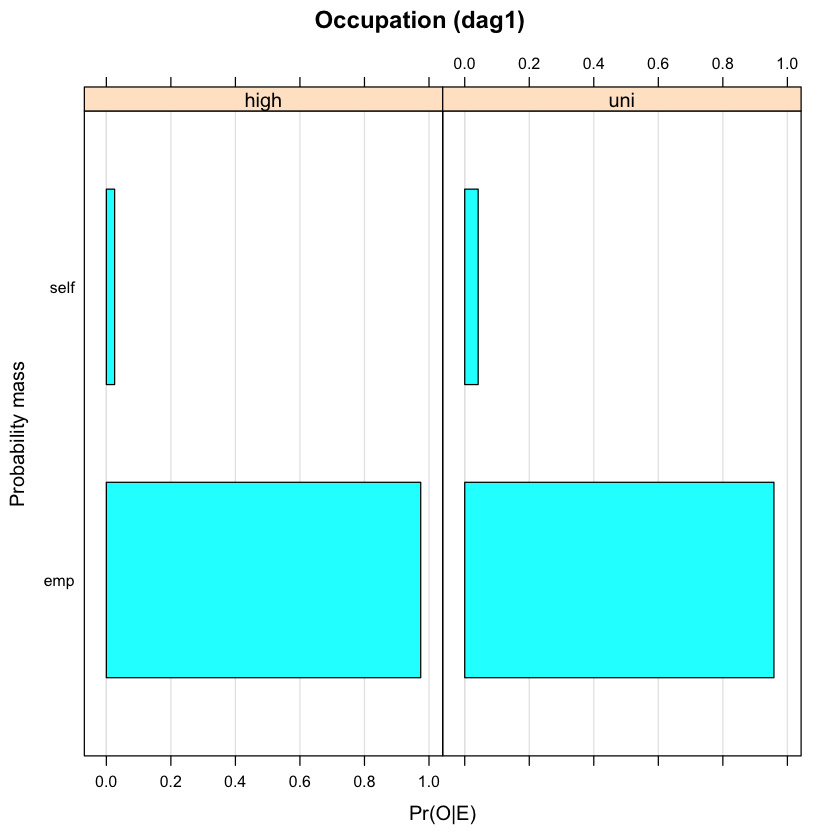

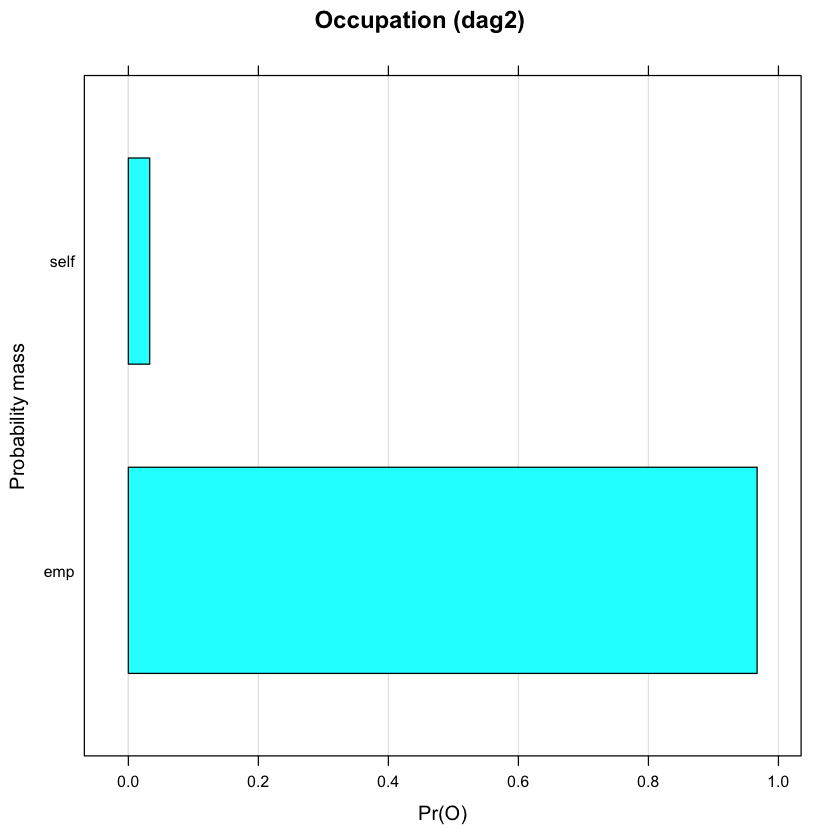

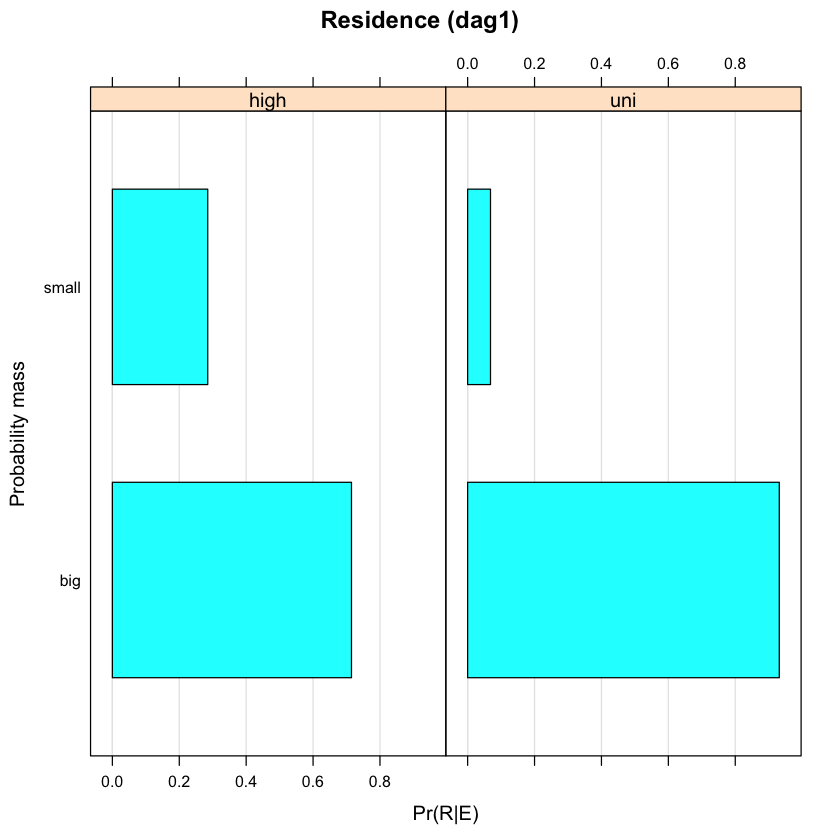

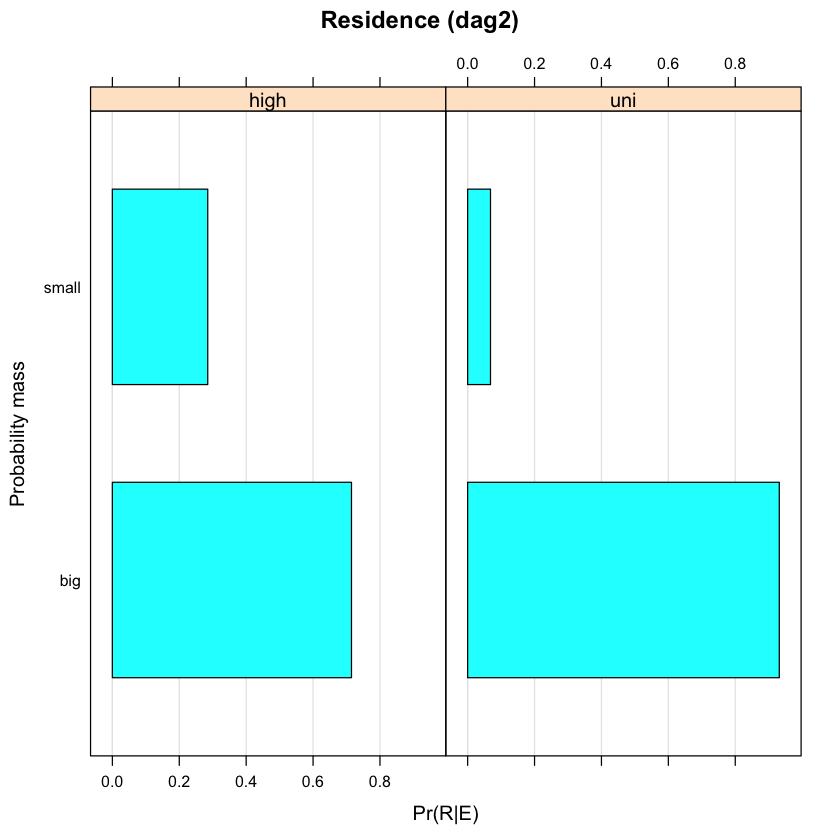

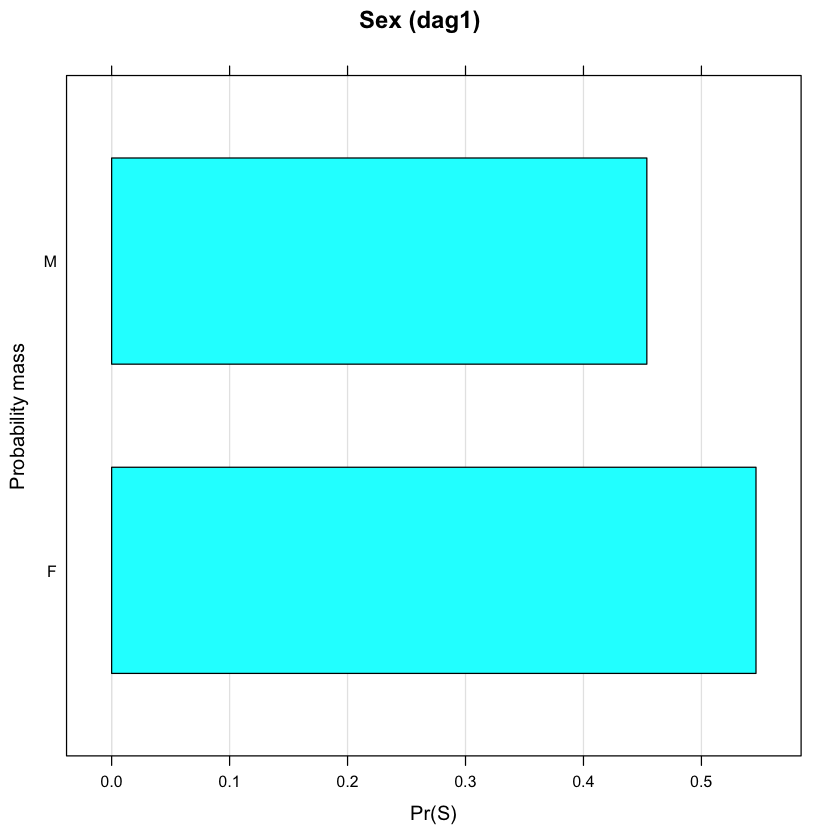

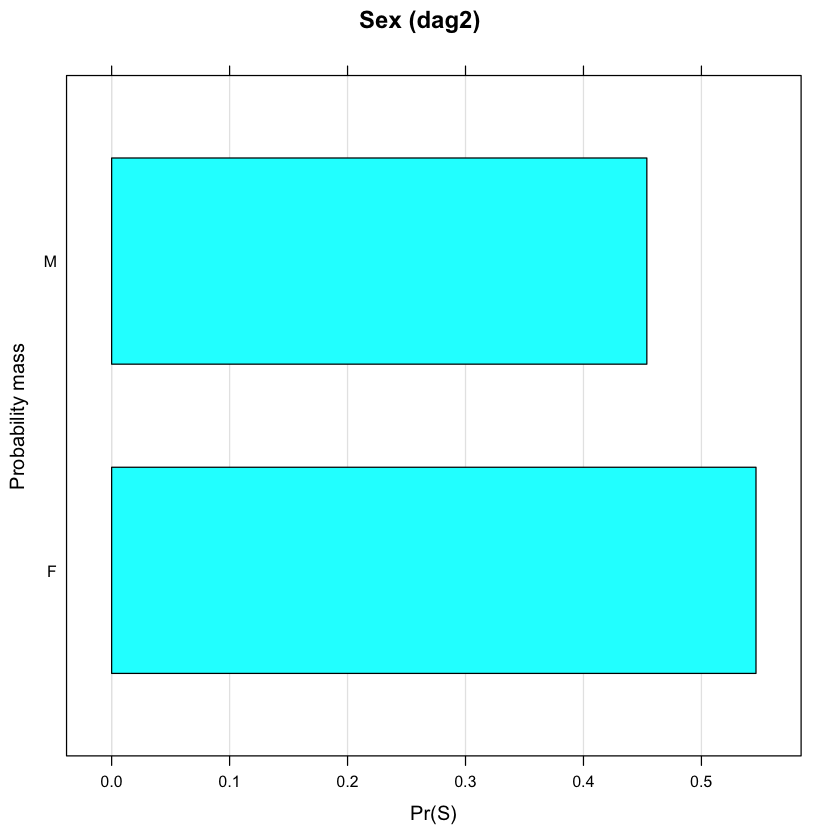

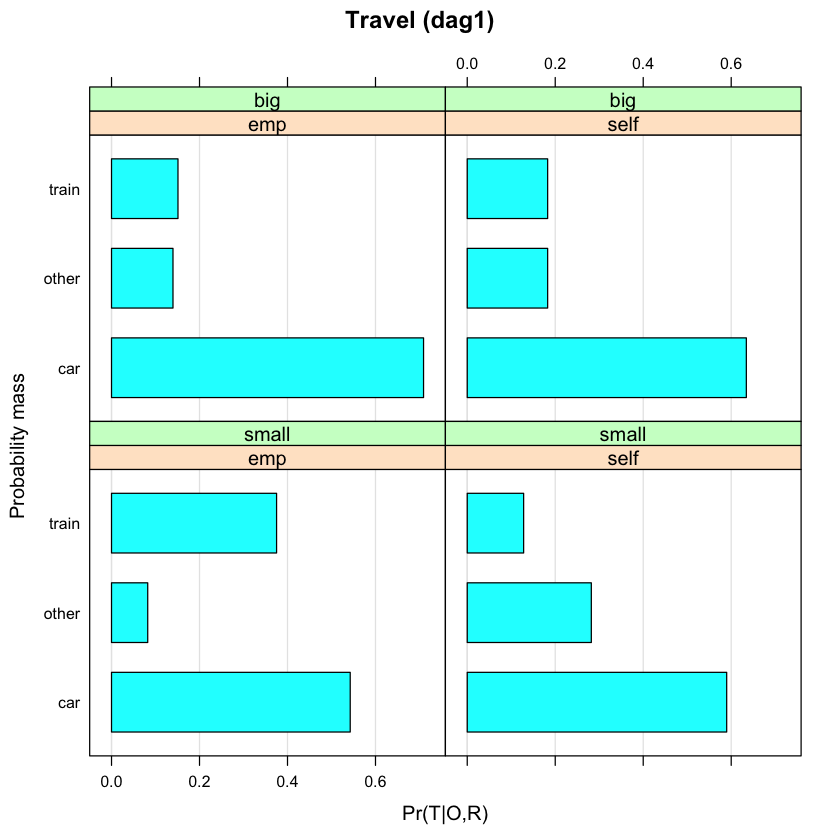

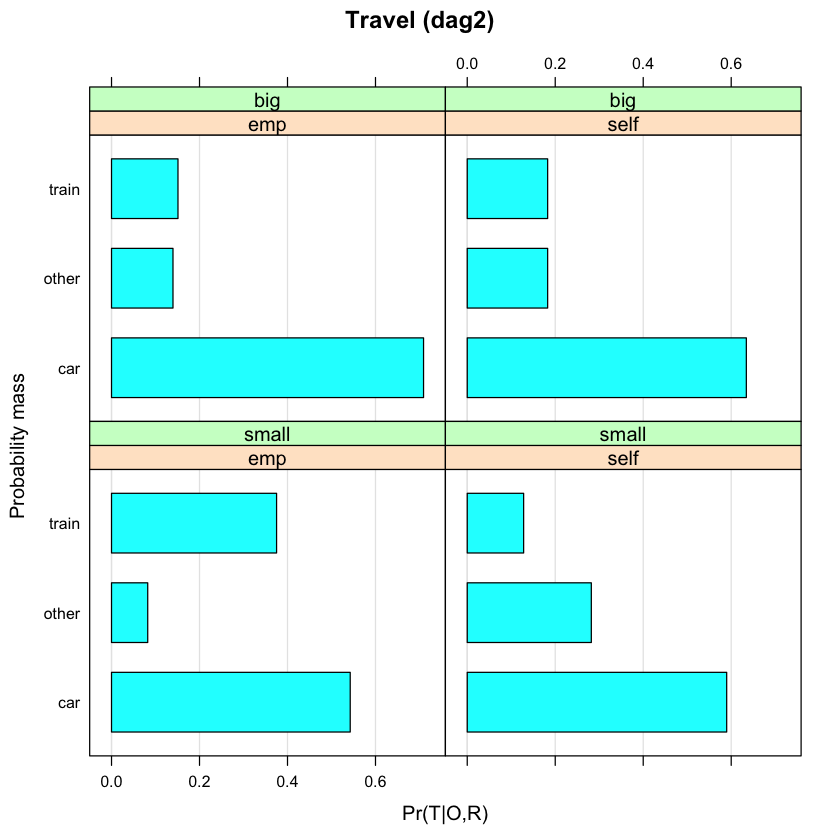

In [13]:
bn.bayes1 <- bn.fit( dagnetwork, data= survey, method= "bayes", iss=10)
bn.bayes2 <- bn.fit( dag2, data= survey, method= "bayes", iss=10)
for( node in nodes(bn.bayes)){
        bn.fit.barchart(bn.bayes1[[node]], 
                        main = paste(node.names[[node]], " (dag1)" ,sep=""),
                        xlab =display.cpd.str(dagnetwork,node) , 
                        ylab = "Probability mass")
        bn.fit.barchart(bn.bayes2[[node]], 
                        main = paste(node.names[[node]], " (dag2)" ,sep=""),
                        xlab =display.cpd.str(dag2,node) , 
                        ylab = "Probability mass")
}

## 5 Markov equivalence (12 points)

### (a) Compute and plot the PDAG of the DAG for the survey data using the `cpdag` function.  Call this PDAG P1 and the original DAG D1.  How does P1 and D1 compare?  Explain any similarities or differences.

#### Answer:
No differences observed

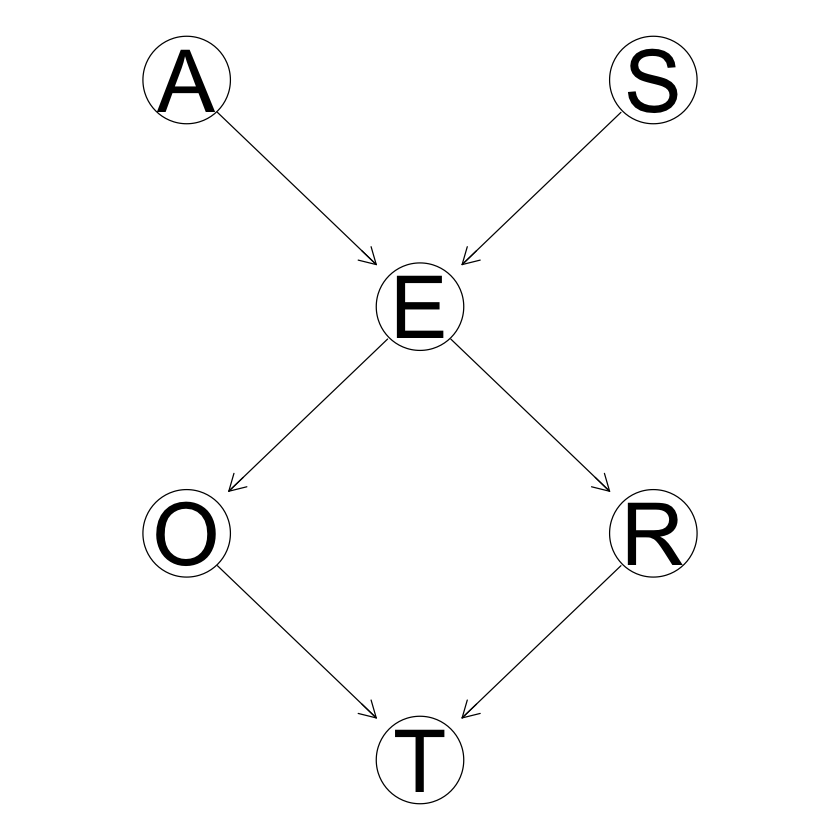

In [23]:
d1 <- dagnetwork
graphviz.plot(d1)

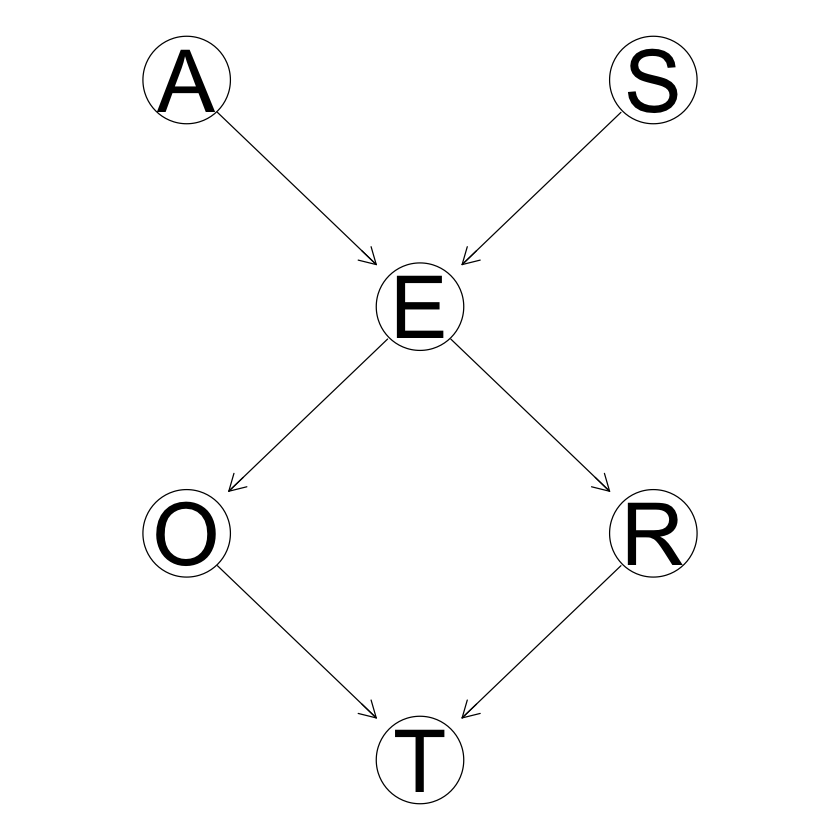

In [24]:
p1 <- cpdag(d1)
graphviz.plot(p1)

### (b) Create a DAG D2 that is the same as D1 except that it has a new arc from Occupation to Residence.  This makes sense because surely somebody's job determines where they live (or is it the other way around?).  Note that this is a fine example of applying domain knowledge about the data generative process in causal model development. Plot the result with `graphviz.plot`.

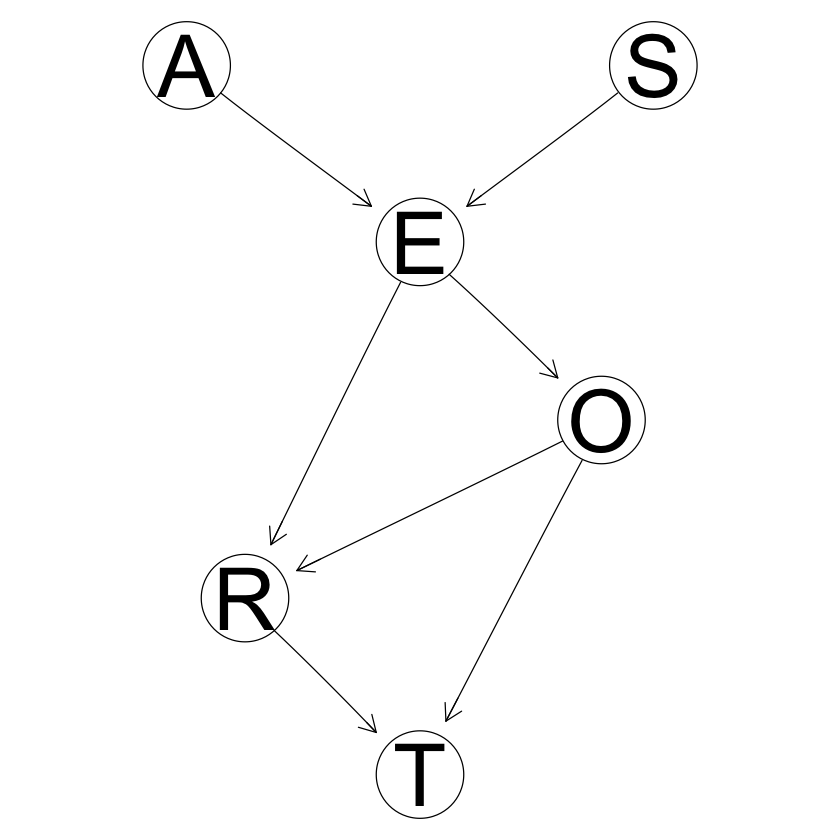

In [25]:
d2 <- set.arc(d1, 'O', 'R')
graphviz.plot(d2)

### (c) Now recompute a PDAG P2 from D2.  What, if anything, is different between P1 and P2 and what explains these differences or lack of differences?
#### Answer:
The difference between $P_1$ and $P_2$ is that there is no edge between Occupation $O$ and Residence $R$ in $P_1$ and there is an undirected edge between Occupation $O$ and Residence $R$ in $P_2$.

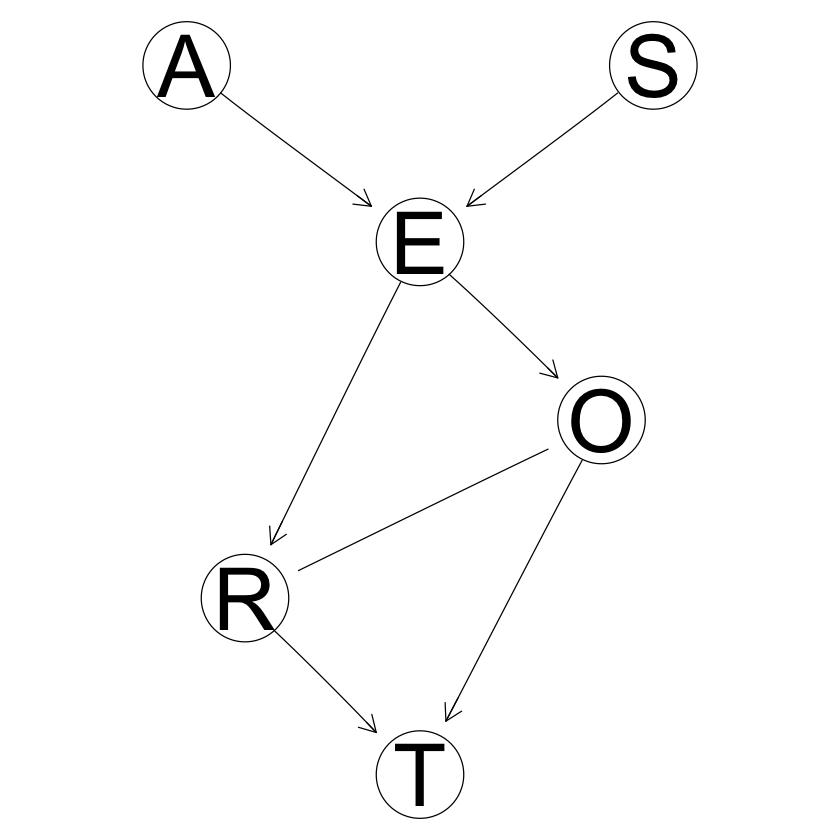

In [31]:
p2 <-cpdag( d2 )
graphviz.plot(p2)

### (d) Create a third DAG D3 that is different from the second DAG (with the O->R edge) but is in the same Markov equivalence class. Do this by reasoning about P2 -- in other words look at P2 and create another DAG D3, such that `cpdag(D3)` will also produce P2.  Plot D3.

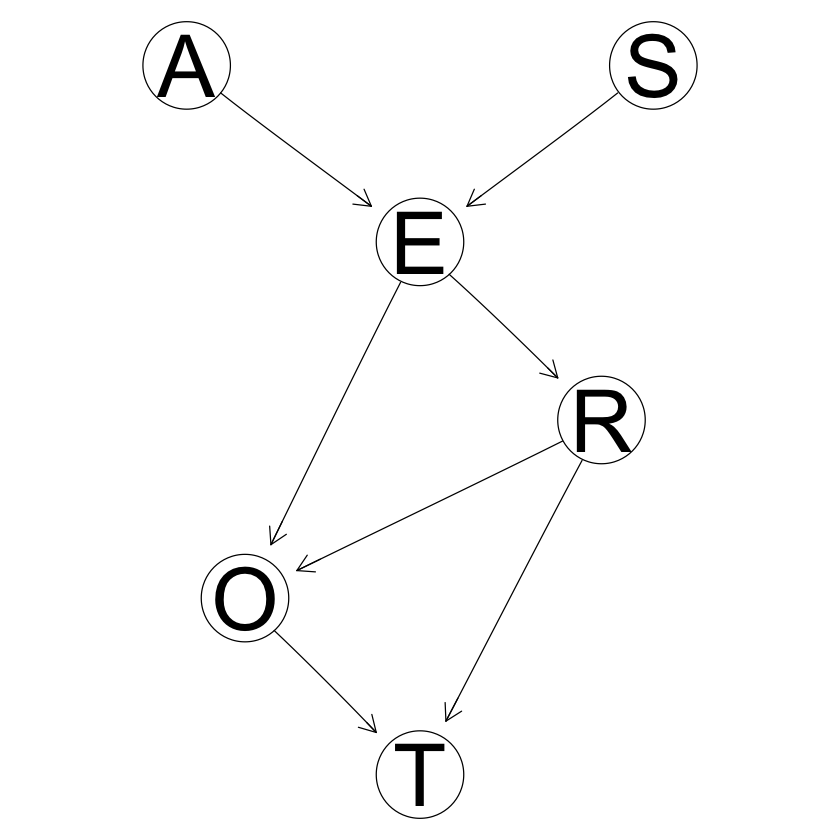

In [32]:
d3 <- set.arc(d1, 'R','O')
graphviz.plot(d3)

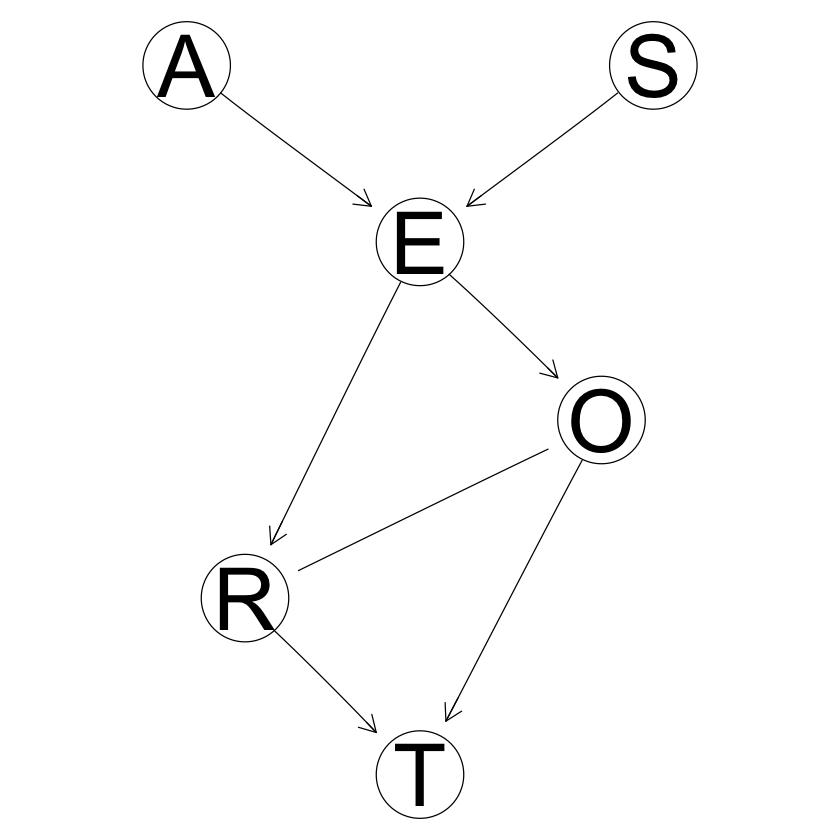

In [33]:
p3 <- cpdag(d3)
graphviz.plot(p3)

### (e) Calculate the log-likelihood of the data given D2 and the log-likelihood of the data given D3.  These values should be the same, explain why.  You can use the `score` function with the argument `type = 'loglik`, or you can simply se the `logLik` function, which is just a wrapper for `score`.  You don't need to provide parameter values for the CPDs of the DAG, `score` will estimate them for you.

#### Answer:
The log-likelihood of the data given $D_2$ should be the same as the log-likelihood of the data given $D_3$ because if their scores were different, then we would have a way of distinguishing between them using data.  However, `cpdag` already showed that $D_2$ and $D_3$ are markov equivalent and we know that we cannot distinguish between two markov equivalent networks just using data.  

In [136]:
score(d1,survey, type = 'loglik')

[1] -2351.839

In [135]:
score(d2, survey,type = 'loglik')

[1] -2350.686

In [134]:
score(d3,survey,type = 'loglik')

[1] -2350.686

## 6 Switching to Pyro (18 points)

### Note: Switch to the Python kernel

If you are new to tensor-based frameworks, make sure you give yourself plenty of time for this question.  It takes time to get used to debugging.  One common source of bugs is integers, *pyro* prefers you use floats (e.g., `torch.tensor(1.0)` instead of `torch.tensor(1)`).  If you hit a bug and solve it, why not share with your classmates on Piazza?

### (a) Use *pyro* to reimplement the Bayesian network with parameter values you fitted in question 3.  Use default *iss* values and round parameter estimates to 2 decimal places.  Show source code.


Answer the following inference questions using `pyro.condition` and (if needed) a *pyro* inference algorithm. 

In [1]:
from statistics import mean
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
%matplotlib inline

pyro.set_rng_seed(101)

A_alias = ['young','adult','old']
S_alias = ['M','F']
E_alias = ['high','uni']
O_alias = ['emp','self']
R_alias = ['small','big']
T_alias = ['car','train','other']

#### Read in the conditional probability distribution for Age that was fitted by `bayes.fit` (with default *iss* values) in question 3.

Reorder the index values so that they correspond to the order in `A_alias` and round to 2 decimal places.

In [2]:
A_df = pd.read_csv('A-node.tab',sep='\t',header=0,names=['A','Freq']).set_index('A').reindex(A_alias).round(2)
A_df

,Freq
A,
young,0.48
adult,0.36
old,0.16


Convert the dataframe representation into a tensor representation with the shape corresponding to what is expected in the model.

In [3]:
A_prob = torch.tensor(A_df.values.squeeze())
A_prob

tensor([0.4800, 0.3600, 0.1600], dtype=torch.float64)

#### Read in the conditional probability distribution for Sex that was fitted by `bayes.fit` (with default *iss* values) in question 3.

Reorder the index values so that they correspond to the order in `S_alias` and round to 2 decimal places.

In [4]:
S_df = pd.read_csv('S-node.tab',sep='\t',header=0,names=['S','Freq']).set_index('S').reindex(S_alias).round(2)
S_df

,Freq
S,
M,0.45
F,0.55


Convert the dataframe representation into a tensor representation with the shape corresponding to what is expected in the model.

In [5]:
S_prob = torch.tensor(S_df.values.squeeze())
S_prob

tensor([0.4500, 0.5500], dtype=torch.float64)

#### Read in the conditional probability distribution for Occupation that was fitted by `bayes.fit` (with default *iss* values) in question 3.

Reorder the index values so that they correspond to the order in `O_alias` and round to 2 decimal places.

In [6]:
O_df = pd.read_csv('O-node.tab',sep='\t').reindex(E_alias,axis=1).reindex(O_alias,axis=0).round(2)
O_df

,high,uni
emp,0.98,0.97
self,0.02,0.03


Convert the dataframe representation into a tensor representation with the shape corresponding to what is expected in the model.

In [7]:
O_prob = torch.tensor(O_df.values.reshape(len(E_alias), len(O_alias)))
O_prob

tensor([[0.9800, 0.9700],
        [0.0200, 0.0300]], dtype=torch.float64)

#### Read in the conditional probability distribution for Residence that was fitted by `bayes.fit` (with default *iss* values) in question 3.

Reorder the index values so that they correspond to the order in `R_alias` and round to 2 decimal places.

In [8]:
R_df = pd.read_csv('R-node.tab',sep='\t').reindex(E_alias,axis=1).reindex(R_alias,axis=0).round(2)
R_df

,high,uni
small,0.28,0.06
big,0.72,0.94


Convert the dataframe representation into a tensor representation with the shape corresponding to what is expected in the model.

In [9]:
R_prob = torch.tensor(R_df.values.reshape(len(E_alias), len(R_alias)))
R_prob

tensor([[0.2800, 0.0600],
        [0.7200, 0.9400]], dtype=torch.float64)

#### Read in the conditional probability distribution for Education that was fitted by `bayes.fit` (with default *iss* values) in question 3.

Reorder the index values so that they correspond to the order in `E_alias` and round to 2 decimal places.

In [10]:
E_df = pd.read_csv('E-node.tab',sep='\t').set_index(['S','A','E']).reindex(S_alias,level='S').reindex(A_alias,level='A').reindex(E_alias, level='E').round(2)
E_df

Freq
S A     E         
M young high  0.81
        uni   0.19
  adult high  0.72
        uni   0.28
  old   high  0.89
        uni   0.11
F young high  0.16
        uni   0.84
  adult high  0.64
        uni   0.36
  old   high  0.84
        uni   0.16

Convert the dataframe representation into a tensor representation with the shape corresponding to what is expected in the model.

In [11]:
E_prob = torch.tensor(E_df.values.reshape(len(S_alias), len(A_alias), len(E_alias)))
E_prob

tensor([[[0.8100, 0.1900],
         [0.7200, 0.2800],
         [0.8900, 0.1100]],

        [[0.1600, 0.8400],
         [0.6400, 0.3600],
         [0.8400, 0.1600]]], dtype=torch.float64)

#### Read in the conditional probability distribution for Transportation that was fitted by `bayes.fit` (with default *iss* values) in question 3.

Reorder the index values so that they correspond to the order in `T_alias` and round to 2 decimal places.

In [12]:
T_df = pd.read_csv('T-node.tab',sep='\t').set_index(['R','O','T']).reindex(R_alias,level='R').reindex(O_alias,level='O').reindex(T_alias, level='T').round(2)
T_df

Freq
R     O    T          
small emp  car    0.55
           train  0.38
           other  0.08
      self car    0.73
           train  0.02
           other  0.25
big   emp  car    0.71
           train  0.15
           other  0.14
      self car    0.69
           train  0.16
           other  0.16

Convert the dataframe representation into a tensor representation with the shape corresponding to what is expected in the model.

In [13]:
T_prob = torch.tensor(T_df.values.reshape(len(R_alias), len(O_alias), len(T_alias)))
T_prob

tensor([[[0.5500, 0.3800, 0.0800],
         [0.7300, 0.0200, 0.2500]],

        [[0.7100, 0.1500, 0.1400],
         [0.6900, 0.1600, 0.1600]]], dtype=torch.float64)

#### Now define the causal model in terms of a data-generating process that samples from the conditional probability distributions of random variables that have the structural properties of the bayesian network.

In [14]:

def model():
    A = pyro.sample("A", dist.Categorical(probs=A_prob))
    S = pyro.sample("S", dist.Categorical(probs=S_prob))
    E = pyro.sample("E", dist.Categorical(probs=E_prob[S][A]))
    O = pyro.sample("O", dist.Categorical(probs=O_prob[E]))
    R = pyro.sample("R", dist.Categorical(probs=R_prob[E]))
    T = pyro.sample("T", dist.Categorical(probs=T_prob[R][O]))
    return{'A': A,'S': S,'E': E,'O': O,'R': R,'T': T}

### (b) You observe a person with a university degree. What is your prediction of this person's means of travel? Provide either a MAP estimate or a histogram of the marginal on the variable "T". 
    

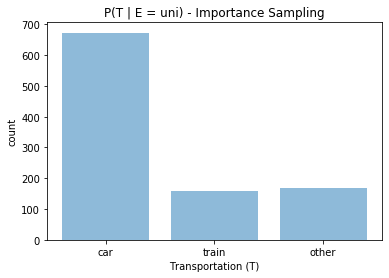

In [18]:
travel_given_education =  pyro.condition(model, data={'E':torch.tensor(1)})
T_posterior = pyro.infer.Importance(travel_given_education, num_samples=5000)
T_posterior.run()
T_marginal = EmpiricalMarginal(T_posterior,"T")
T_samples = [T_marginal().item() for _ in range(1000)]
T_unique, T_counts = np.unique(T_samples, return_counts=True)

plt.bar(T_unique, T_counts, align='center', alpha=0.5)
plt.xticks(T_unique, T_alias)
plt.ylabel('count')
plt.xlabel('Transportation (T)')
plt.title('P(T | E = uni) - Importance Sampling')
plt.show()

### (c) You observe a self-employed person who lives in a big city. What is your prediction of this person's age?  Provide either a MAP estimate or a histogram of the marginal on the variable "A".  

Hint: An exact inference algorithm such as variable elimination could work here, but it can become intractable on certain networks. One class of approximate inference methods uses random sampling to approximate the distribution. One sampling approach used to answer inference question given observation is rejection sampling. However, it can be wasteful because it rejects all the samples that do not match the observation. A more efficient sampling approach is importance sampling (http://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.importance). We encourage you to experiment with different inference methods in Pyro. Detailed understanding about how these methods work is not the focus or requirement of this course. This course only requires a high level understand of Bayesian inference methods and being able to use them in Pyro.

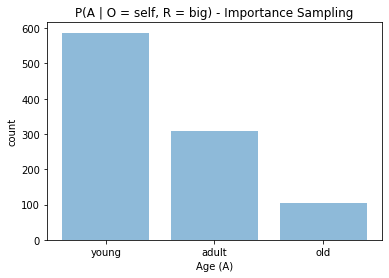

In [19]:
age_given_occupation_and_residence =  pyro.condition(model, data={'O':torch.tensor(1), 'R':torch.tensor(1)})
A_posterior = pyro.infer.Importance(age_given_occupation_and_residence, num_samples=5000)
A_posterior.run()
A_marginal = EmpiricalMarginal(A_posterior,"A")
A_samples = [A_marginal().item() for _ in range(1000)]
A_unique, A_counts = np.unique(A_samples, return_counts=True)

plt.bar(A_unique, A_counts, align='center', alpha=0.5)
plt.xticks(A_unique, A_alias)
plt.ylabel('count')
plt.xlabel('Age (A)')
plt.title('P(A | O = self, R = big) - Importance Sampling')
plt.show()